<center><h2> Collaborative Filtering for Movie Recommendations</h2></center> 


In [15]:
# importing all necessary libraries 
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile

import keras
from keras import layers
from keras import ops

## First, load the data and apply preprocessing

In [7]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [8]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
#First, need to perform some preprocessing to encode users and movies as integer indices.
#converting userId and movieId from categorical to numerical data
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [12]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


## Prepare training and validation data


In [16]:
df = df.sample(frac=1, random_state=42) #help prevent any unintentional ordering bias
x = df[["user", "movie"]].values #extracting input feature from df as Numpy Array
#Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Create the model


In [20]:
EMBEDDING_SIZE = 50

#neural network model RecommenderNet using TensorFlow/Keras, designed for recommendation systems based on collaborative filtering
class RecommenderNet(keras.Model): #Sets up the architecture and parameters of the recommender neural network
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs): #Defines how inputs are processed to make predictions (inference).
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE) #Instantiates the recommender model and prepares it for training.
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

## Train the model based on the data split


In [21]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6566 - val_loss: 0.6200
Epoch 2/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.6161 - val_loss: 0.6209
Epoch 3/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6089 - val_loss: 0.6141
Epoch 4/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6092 - val_loss: 0.6114
Epoch 5/5
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.6079 - val_loss: 0.6116


## Plot training and validation loss


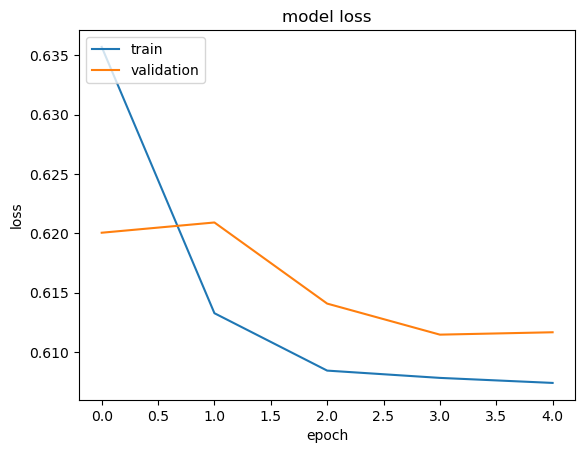

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

## Show top 10 movie recommendations to a user

In [25]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
Showing recommendations for user: 474
Movies with high ratings from user
--------------------------------
Fugitive, The (1993) : Thriller
Remains of the Day, The (1993) : Drama|Romance
West Side Story (1961) : Drama|Musical|Romance
X2: X-Men United (2003) : Action|Adventure|Sci-Fi|Thriller
Spider-Man 2 (2004) : Action|Adventure|Sci-Fi|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Ghost in the Shell (Kôkaku kidôtai) (1995) : Animation|Sci-Fi
Lock, Stock & Two Smoking Barrels (1998) : Comedy|Crime|Thriller
Boondock Saints, The (2000) : Action|Crime|Drama|Thriller
Snatch (2000) : Comedy|Crime|Thriller
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
WALL·E (2008) : Adventure|Animation|Children|Romance|Sci-Fi
Fantastic Mr. Fox (2009) : Adventure|Animation|Children|Comedy|Crime
Toy Story 3 (2010) : Adventure|Animation|Children|Comedy|Fantasy|IMAX
King's Speech, The (2010) : Drama
Logan (2017) :